# Cài đạt Các Thư viện cần thiết
# Sử dụng: PyTorch + OpenCV
# Dataset: FER2013

# download FER2013

In [ ]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

In [1]:
!pip install opencv-python torch torchvision


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached torchvision-0.24.1-cp312-cp312-win_amd64.whl.metadata (5.9 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached torch-2.9.1-cp312-cp312-win_amd64.whl.metadata (30 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
Using cached torchvision-0.24.1-cp312-cp312-win_amd64.whl (4.3 MB)
Using cached torch-2.9.1-cp312-cp312-win_amd64.whl (110.9 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

    Uninstalling numpy-1.26.4:

      Successfully uninstalled numpy-1.26.4

   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   --

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.26 requires langchain-core<1.0.0,>=0.3.66, but you have langchain-core 0.2.37 which is incompatible.
langchain-pinecone 0.2.8 requires langchain-core<1.0.0,>=0.3.34, but you have langchain-core 0.2.37 which is incompatible.
langchain-tests 0.3.22 requires langchain-core<2.0.0,>=0.3.77, but you have langchain-core 0.2.37 which is incompatible.
pandas 2.2.0 requires numpy<2,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.
scipy 1.12.0 requires numpy<1.29.0,>=1.22.4, but you have numpy 2.2.6 which is incompatible.


In [2]:
import cv2
img=cv2.imread(r"img_1.png")

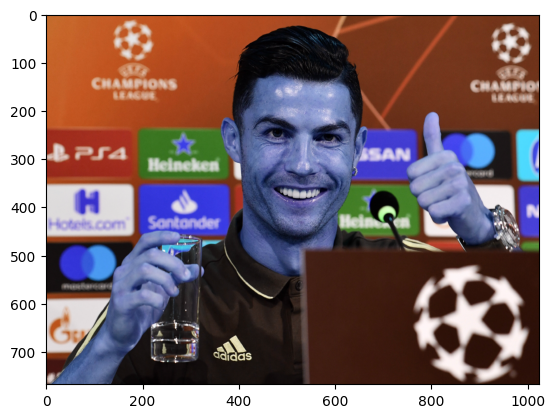

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img) #BGR

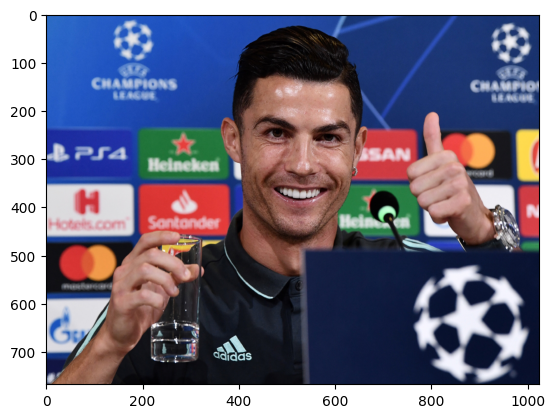

In [18]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# Thiết lập Model Và Huấn Luyện Mô Hình

In [8]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

## 1.Tạo Model FER_C

In [5]:
class FER_CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FER_CNN, self).__init__()
        # 3 layer Conv + MaxPool
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        # Fully connected
        self.fc1 = nn.Linear(128*24*24, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## 2. Setup GPU , Labels

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

## 3. Tiền Xử lý dữ liệu

In [9]:
data_dir = r"D:\FINE-GRAINED-EMOTION-PREDICT\datasets\msambare\fer2013\versions\1"

transform = transforms.Compose([
    transforms.Grayscale(),            # 1 channel
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False)

In [15]:
print(test_loader)

## 4. Huấn Luyện Mô Hình